# Taller 1: Análisis de señales de electroencefalografía



**Facultad de ingeniería, departamento de Ingeniería Biomédica, Universidad de los Andes**\
**Curso de extensión**

Autor: Moshé Amarillo - MIT license

# **Introducción**

El cerebro está activo en todo momento, es capaz de producir actividad de manera espontánea en forma de oscilaciones que pueden ser medidas utilizando distintos métodos, una de las técnicas más utilizadas es la electroencefalografía (EEG) que consiste en colocar electrodos en la superficie de la cabeza para detectar la actividad eléctrica producida por las neuronas.

<div>
<img src="https://cdn.shopify.com/s/files/1/2285/0379/articles/Electroencefalografia_Technomed_960x.png?v=1675279881" width="500"/>
</div>

La actividad cerebral se estima a una tasa contínua produciendo una serie de temporal (una serie de valores organizados en el tiempo) que puede ser analizada para diagnosticar enfermedades o investigar procesos básicos y aplicados.

La presente práctica haremos uso de un conjunto de datos obtenidos durante una tarea de olfateo de aromas. El objetivo es explorar cómo la actividad cerebral, registrada a través del EEG, puede proporcionar información sobre la respuesta del cerebro a los estímulos olfativos. El proceso consistirá en que los participantes huelan diferentes aromas mientras se registran sus señales cerebrales mediante electrodos colocados en su cuero cabelludo.

In [ ]:
# @title Funciones importantes (ejecutar)
%pip install -q ipywidgets
%matplotlib inline
!pip uninstall gdown -y && pip install gdown
!gdown -V
!gdown --fuzzy https://drive.google.com/file/d/1h2N1575goCX-K8B1uSYOjN4NqoTT1KXq/view?usp=sharing

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
from scipy import signal
from scipy import stats


def f_IIRBiFilter(p_FiltSOS, p_XIn):
    return signal.sosfiltfilt(p_FiltSOS, p_XIn)

def f_GetIIRFilter(p_FsHz, p_PassFreqHz, p_StopFreqsHz):
    #p_FsHz: Frecuencia de muestreo
    #Banda de corte
    #Banda de rechazo
    s_AMaxPassDb = 0.5
    s_AMinstopDb = 120
    s_NyFreqHz = p_FsHz / 2
    p_PassFreqHz = np.array(p_PassFreqHz) / s_NyFreqHz
    p_StopFreqsHz = np.array(p_StopFreqsHz) / s_NyFreqHz

    s_N, v_Wn = signal.cheb2ord(p_PassFreqHz, p_StopFreqsHz, s_AMaxPassDb, s_AMinstopDb)
    #print('f_GetIIRFilter - Filter order: ' + np.str(s_N))
    filt_FiltSOS = signal.cheby2(s_N, s_AMinstopDb, v_Wn, btype='bandpass', output='sos')

    return filt_FiltSOS

def f_GaborTFTransform(p_XIn, p_FsHz, p_F1Hz, p_F2Hz, p_FreqResHz, p_NumCycles):
    # Creamos un vector de tiempo en segundos
    v_TimeArray = np.arange(0, np.size(p_XIn)) / p_FsHz

    # Definimos un rango de frecuencias
    # las cuales usaremos para crear nuestros
    # patrones oscilatorios de prueba
    # En este caso generaremos patrones para
    # frecuencias entre 1 y 20 Hz con pasos
    # de 0.25 Hz
    v_FreqTestHz = np.arange(p_F1Hz, p_F2Hz + p_FreqResHz, p_FreqResHz)

    # Creamos una matriz que usaremos para
    # almacenar el resultado de las
    # convoluciones sucesivas. En esta matriz,
    # cada fila corresponde al resultado de
    # una convolución y cada columna a todos
    # los desplazamientos de tiempo.
    m_ConvMat = np.zeros([np.size(v_FreqTestHz), np.size(p_XIn)], dtype=complex)

    # Se obtiene la transformada de Fourier
    # de la señal p_XIn para usarla en cada iteración
    p_XInfft = np.fft.fft(p_XIn)

    # Ahora creamos un procedimiento iterativo
    # que recorra todas las frecuencias de prueba
    # definidas en el arreglo v_FreqTestHz
    for s_FreqIter in range(np.size(v_FreqTestHz)):
        # Generamos una señal sinusoidal de prueba
        # que oscile a la frecuencia de la iteración
        # s_FreqIter (v_FreqTestHz[s_FreqIter]) y que tenga
        # la misma longitud que la señal p_XIn.
        # En este caso usamos una exponencial compleja.
        xtest = np.exp(1j * 2.0 * np.pi * v_FreqTestHz[s_FreqIter] * v_TimeArray)

        # Creamos una ventana gaussina para
        # limitar nuestro patrón en el tiempo
        # Definimos la desviación estándar de
        # acuerdo al número de ciclos definidos
        # Dividimos entre 2 porque para un ventana
        # gaussiana, una desviación estándar
        # corresponde a la mitad del ancho de la ventana
        xtestwinstd = ((1.0 / v_FreqTestHz[s_FreqIter]) * p_NumCycles) / 2.0
        # Definimos nuestra ventana gaussiana
        xtestwin = np.exp(-0.5 * (v_TimeArray / xtestwinstd) ** 2.0)
        # Multiplicamos la señal patrón por
        # la ventana gaussiana
        xtest = xtest * xtestwin

        # Para cada sinusoidal de prueba obtenemos
        # el resultado de la convolución con la señal p_XIn
        # En este caso nos toca calcular la convolución
        # separadamente para la parte real e imaginaria
        # m_ConvMat[s_FreqIter, :] = np.convolve(p_XIn, np.real(xtest), 'same') + \
        #                        1j * np.convolve(p_XIn, np.imag(xtest), 'same')

        # Se obtine la transformada de Fourier del patrón
        fftxtest = np.fft.fft(xtest)
        # Se toma únicamente la parte real para evitar
        # corrimientos de fase
        fftxtest = abs(fftxtest)
        # Se obtine el resultado de la convolución realizando
        # la multiplicación de las transformadas de Fourier de
        # la señal p_XIn por la del patrón
        m_ConvMat[s_FreqIter, :] = np.fft.ifft(p_XInfft * fftxtest)

    return m_ConvMat, v_TimeArray, v_FreqTestHz


def f(Electrodo, Filtrar,Pasa_bajas,Pasa_altas,Tiempo_inicial,Tiempo_final,yinferior,ysuperior):
  idx = ['Fp1', 'Fp2', 'T3', 'T4', 'C3', 'C4', 'O1', 'O2'].index(Electrodo)
  v_signal1 = stats.zscore(v_signal[idx,:])
  if Filtrar:
    st_Filt = f_GetIIRFilter(s_FsHz, [Pasa_altas,Pasa_bajas], [Pasa_altas-0.5, Pasa_bajas+0.5])
    v_DataFilt = f_IIRBiFilter(st_Filt,v_signal1) #1p Filtro creado, señal a filtrar
    #plt.plot(v_time,v_DataFilt)
    plt.plot(v_time,v_DataFilt, 'r' , linewidth=0.75)
    plt.xlim([Tiempo_inicial,Tiempo_final])
    plt.ylim([yinferior,ysuperior])

    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (V)')
    plt.grid()
    plt.show()
  else:
    plt.plot(v_time,v_signal1, 'r' ,linewidth=0.75)
    plt.xlim([Tiempo_inicial,Tiempo_final])
    plt.ylim([yinferior,ysuperior])
    plt.grid()
    plt.show()
  return
def graph_tf(Electrodo,Tiempo,Freq_baja,Freq_alta):
    idx = ['Fp1', 'Fp2', 'T3', 'T4', 'C3', 'C4', 'O1', 'O2'].index(Electrodo)
    window = 10
    ini = int((Tiempo-window) * s_FsHz)
    fin = int((Tiempo+window) * s_FsHz)
    st_Filt = f_GetIIRFilter(s_FsHz, [1,30], [1-0.5, 30+0.5])
    v_DataFilt = f_IIRBiFilter(st_Filt,v_signal[idx,:]) #1p Filtro creado, señal a filtrar
    v_signal1 = v_DataFilt[ini:fin]
    #plt.plot(v_signal1)
    m_ConvMat, v_TimeArray, v_FreqTestHz = f_GaborTFTransform(v_signal1, s_FsHz,Freq_baja, Freq_alta, 0.1, 10)
    v_TimeArray_1 = Tiempo + (v_TimeArray - (v_TimeArray[-1]/2))
    plt.subplot(2,1,1)
    plt.contourf(v_TimeArray_1,v_FreqTestHz,abs(m_ConvMat), cmap = 'hot')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia (Hz)')
    plt.subplot(2,1,2)
    plt.plot(v_TimeArray_1,v_signal1, 'r' , linewidth=0.75)
    plt.xlim([v_TimeArray_1[0],v_TimeArray_1[-1]])
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Voltaje (uV)')
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_ERP(v_triggerTime,v_triggerTime_p300):#Ver señal al rededor de triggers
  d_SampleRate = s_FsHz

  d_windSize = 0.6
  d_iniTime = -0.2
  d_exhibithionTime = 0.05 * 1000

  d_chann = 1
  st_Filt = f_GetIIRFilter(s_FsHz, [1,30], [1-0.5, 30+0.5])
  v_data = f_IIRBiFilter(st_Filt,v_signal[1,:].T) #1p Filtro creado, señal a filtrar

  fig, ax = plt.subplots(2, 1, figsize=(11, 7))

  v_allDataWind = []
  v_allDataWind_p300 = []
  for i_trigger in range(len(v_triggerTime)):

      v_dataWind = v_data[int((v_triggerTime[i_trigger] + d_iniTime) * d_SampleRate): int(
          (v_triggerTime[i_trigger] + d_windSize) * d_SampleRate)]

      v_allDataWind.append(v_dataWind)

      v_dataWind_p300 = v_data[int((v_triggerTime_p300[i_trigger] + d_iniTime) * d_SampleRate): int(
          (v_triggerTime_p300[i_trigger] + d_windSize) * d_SampleRate)]

      v_allDataWind_p300.append(v_dataWind_p300)

      v_timeWind = np.linspace(d_iniTime, d_windSize, len(v_dataWind)) * 1000

      if i_trigger == 0:
          ax[0].plot(v_timeWind, v_dataWind, 'k', label='Olor Neutro', linewidth=0.75)
          ax[0].plot(v_timeWind, v_dataWind_p300, 'r', label='Aroma', linewidth=0.75)
      else:
          ax[0].plot(v_timeWind, v_dataWind, 'k', linewidth=0.75)
          ax[0].plot(v_timeWind, v_dataWind_p300, 'r', linewidth=0.75)

  ax[0].set_title('Todos los eventos')
  ax[0].axvline(0, color ='Grey', linewidth = '1.75', linestyle='--')
  ax[0].text(-15, 25, 'Event', rotation='vertical', fontsize=9)

  for spin in ['top', 'right', 'bottom', 'left']:
      ax[0].spines[spin].set_visible(False)
      ax[0].get_xaxis().set_ticks([])

  ax[0].set_ylabel('Voltaje [uV]')
  ax[0].legend()

  v_allDataWindMean = np.mean(np.array(v_allDataWind), 0)
  v_allDataWindMean_p300 = np.mean(np.array(v_allDataWind_p300), 0)

  ax[1].set_title('Señal promedio')
  ax[1].plot(v_timeWind, v_allDataWindMean, 'k', label='Olor Neutro', linewidth=1.5, linestyle='--')
  ax[1].plot(v_timeWind, v_allDataWindMean_p300, 'r', label='Aroma', linewidth=1.5)
  ax[1].axvline(0, color ='Grey', linewidth = '1.75', linestyle='--')
  ax[1].axvspan(250, 350, alpha=0.25, color='grey', linewidth = 0)
  ax[1].text(-15, 5, 'Event', rotation='vertical', fontsize=9)
  ax[1].text(255, -30, 'Respuesta Evocada', fontsize=9)

  for spin in ['top', 'right', 'left']:
      ax[1].spines[spin].set_visible(False)

  ax[1].set_ylabel('Voltaje [uV]')
  ax[1].set_xlabel('Tiempo [ms]')
  ax[1].legend()
  plt.tight_layout()

In [ ]:
# @title Cargar datos de EEG
EEG_struc = scio.loadmat('EEG.mat')
v_signal = EEG_struc['m_Data']
s_FsHz = EEG_struc['s_Freq'][0]
v_time = np.arange(0,np.size(v_signal,1)/s_FsHz,1/s_FsHz)


In [ ]:
# @title Ver señal de EEG
interact(f, Electrodo = ['Fp1', 'Fp2', 'T3', 'T4', 'C3', 'C4', 'O1', 'O2'],
         Filtrar=True,
         Pasa_bajas= widgets.IntSlider(min=1, max=30, step=1, value=10),
         Pasa_altas= widgets.IntSlider(min=1, max=30, step=1, value=1),
         Tiempo_inicial = widgets.IntSlider(min=0, max=max(v_time), step=1, value=0),
         Tiempo_final =widgets.IntSlider(min=0, max=max(v_time), step=1, value=max(v_time)),
         yinferior = widgets.FloatSlider(min=-5, max=5, step=0.1, value=-3),
         ysuperior = widgets.FloatSlider(min=-5, max=5, step=0.1, value=3))

interactive(children=(Dropdown(description='Electrodo', options=('Fp1', 'Fp2', 'T3', 'T4', 'C3', 'C4', 'O1', '…

<function __main__.f(Electrodo, Filtrar, Pasa_bajas, Pasa_altas, Tiempo_inicial, Tiempo_final, yinferior, ysuperior)>

In [ ]:
# @title Análisis Tiempo-Frecuencia
interact(graph_tf,
         Electrodo = ['Fp1', 'Fp2', 'T3', 'T4', 'C3', 'C4', 'O1', 'O2'],
         Tiempo = widgets.IntSlider(min=10, max=max(v_time), step=1, value=20),
         Freq_baja=widgets.IntSlider(min=1, max=30, step=1, value=1),
         Freq_alta=widgets.IntSlider(min=1, max=30, step=1, value=10))

interactive(children=(Dropdown(description='Electrodo', options=('Fp1', 'Fp2', 'T3', 'T4', 'C3', 'C4', 'O1', '…

<function __main__.graph_tf(Electrodo, Tiempo, Freq_baja, Freq_alta)>

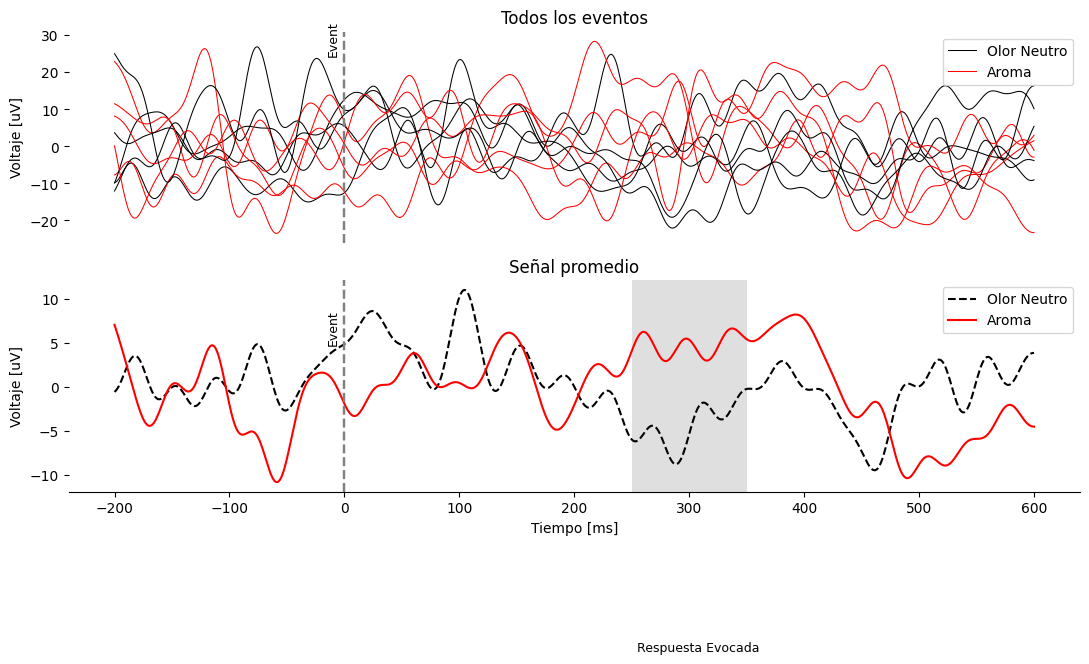

In [ ]:
# @title Potenciales relacionados con eventos (ERP)
lista_1 = [13*60+36,13*60+44,14*60+2,14*60+9,14*60+24]
lista = [13*60+52,14*60+16,12*60+20,12*60+40,13*60+2]
Tiempos_olor_neutro = lista_1 ## Colocar tiempos en segundos
Tiempos_aroma = lista     ## Colocar tiempos en segundos
plot_ERP(Tiempos_olor_neutro,Tiempos_aroma)